## The purpose of the Capstone 2 project is to determine whether or not the lesion in an image is malignant or not 

import necessary libraries

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from numpy import array, newaxis, expand_dims

Using TensorFlow backend.
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/seo/environments/my_env/lib/p

In [2]:
%run functions.py

In [3]:
path="/home/seo/ISIC_DATA/"
process_path='/home/seo/jupyter/Capstone2'
filelist=os.listdir(path)
processfiles=os.listdir(process_path)
meta=[file for file in filelist if not file.endswith(".jpeg") and not file.endswith(".png") and file.startswith("ISIC")]
pics=[file for file in filelist if (file.endswith(".jpeg") or file.endswith(".png")) and file.startswith("ISIC")]

import model that was made in "Building UNET model for image segmentation"

In [5]:
import pickle
model=pickle.load(open('model_fitted.pickle',"rb"))

W0922 19:49:34.533423 140179311347520 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0922 19:49:34.572806 140179311347520 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0922 19:49:34.619629 140179311347520 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 19:49:34.621099 140179311347520 deprecation_wrapper.py:119] From /home/seo/environments/my_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated

In [5]:
seg_files=[file for file in processfiles if file.split('_')[0]=='seg']

In [6]:
print(seg_files)

['seg_15999.p', 'seg_5999.p', 'seg_3999.p', 'seg_11999.p', 'seg_1999.p', 'seg_7999.p', 'seg_13999.p', 'seg_17999.p', 'seg_21999.p', 'seg_19999.p', 'seg_9999.p']


In [7]:
master_dict=dict()
for name in seg_files:
    temp=pickle.load(open(name,'rb'))
    master_dict.update(temp)

In [13]:
len(master_dict)

18975

In [14]:
def symmetry(rotated_roi,contoursize):
    imageO=rotated_roi
    imageLR=np.fliplr(rotated_roi)
    imageUD=np.flipud(rotated_roi)
    lr=mse(rotated_roi, np.fliplr(rotated_roi),contourSize)
    ud=mse(rotated_roi, np.flipud(rotated_roi),contourSize)
    return lr,ud

In [15]:
sym_dict=dict()
cont_dict=dict()
good_imgs=list()
for key in master_dict.keys():
    sym_check=master_dict[key]
    label='_'.join(key.split('_')[0:2])
    cnts,h=cv2.findContours(sym_check[:,:,0],cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE )
    try:
        cnt=cnts[0]
        M = cv2.moments(cnt)
        (a,b),(MA,ma),angle = cv2.fitEllipse(cnt)
        a=int(a)
        b=int(b)
        contourSize = cv2.contourArea(cnt)
        if contourSize!=0:
            good_imgs.append(key)
            cont_dict[key]=cnt
    except:
        continue


    rotated_roi1=rotate_bound(sym_check[:,:,0],angle,a,b)
    rotated_roi2=rotate_bound(sym_check[:,:,1],angle,a,b)
    rotated_roi3=rotate_bound(sym_check[:,:,2],angle,a,b)
    lr1,ud1=symmetry(rotated_roi1,contourSize)
    lr2,ud2=symmetry(rotated_roi2,contourSize)
    lr3,ud3=symmetry(rotated_roi3,contourSize)
    lr=np.mean([lr1,lr2,lr3])
    ud=np.mean([ud1,ud2,ud3])
    sym_dict[label]=np.mean([lr,ud])
    

In [16]:
print(len(sym_dict))

16534


In [10]:
blue_dict=dict()
green_dict=dict()
red_dict=dict()
for key in good_imgs:
    colorcheck=master_dict[key]
    label='_'.join(key.split('_')[0:2])
    color = ('b','g','r')
    #fig=plt.figure()
    zerovalues=list()
    #ax=fig.add_subplot(2,1,1)
    for i,col in enumerate(color):
        histr = cv2.calcHist([colorcheck],[i],None,[256],[0,256])
        #ax.plot(histr,color = col)
        zerovalues.append(histr[0])
        histr=histr[1:]
        #plt.xlim([0,255])
        #ax.set_yscale('log')
        if col=='b':
            blue_dict[label]=histr.std()
        if col=='g':
            green_dict[label]=histr.std()
        if col=='r':
            red_dict[label]=histr.std()

In [15]:
bor_files=[file for file in processfiles if file.split('_')[0]=='bor']
temp_bor_dict=dict()
for name in bor_files:
    temp=pickle.load(open(name,'rb'))
    temp_bor_dict.update(temp)
already_done=temp_bor_dict.keys()
print(already_done)

dict_keys(['ISIC_0026298', 'ISIC_0000103', 'ISIC_0034100', 'ISIC_0003308', 'ISIC_0031002', 'ISIC_0001770', 'ISIC_0009028', 'ISIC_0013304', 'ISIC_0005499', 'ISIC_0024932', 'ISIC_0009080', 'ISIC_0009169', 'ISIC_0032009', 'ISIC_0004381', 'ISIC_0034161', 'ISIC_0028911', 'ISIC_0013639', 'ISIC_0032532', 'ISIC_0032794', 'ISIC_0000115', 'ISIC_0000743', 'ISIC_0026843', 'ISIC_0033950', 'ISIC_0002941', 'ISIC_0007688', 'ISIC_0032452', 'ISIC_0014688', 'ISIC_0014944', 'ISIC_0008099', 'ISIC_0004881', 'ISIC_0024835', 'ISIC_0010774', 'ISIC_0024455', 'ISIC_0024564', 'ISIC_0008763', 'ISIC_0007868', 'ISIC_0032729', 'ISIC_0005971', 'ISIC_0011617', 'ISIC_0025849', 'ISIC_0006299', 'ISIC_0027737', 'ISIC_0006602', 'ISIC_0002177', 'ISIC_0010824', 'ISIC_0000485', 'ISIC_0025328', 'ISIC_0006173', 'ISIC_0026328', 'ISIC_0033288', 'ISIC_0027766', 'ISIC_0012382', 'ISIC_0028068', 'ISIC_0007524', 'ISIC_0032954', 'ISIC_0004822', 'ISIC_0008243', 'ISIC_0009249', 'ISIC_0013806', 'ISIC_0025743', 'ISIC_0033583', 'ISIC_0006178

In [16]:
len(already_done)

17304

In [21]:
border_dict=dict()
#for key in good_imgs:
for key in new_list2:
    try:
        key='_'.join([key,'segmented'])
        border_check=master_dict[key]
        cnt=cont_dict[key]
        label='_'.join(key.split('_')[0:2])
        orig_img=label+'.jpeg'
        resized_orig=resize(call_image(path+orig_img), (128, 128, 1), mode = 'constant', 
                      preserve_range = True)
        H,W = resized_orig.shape[:2]
        h=20; w=20
        tots_gradient=[]
        for point in cnt[:,0]:
            x=point[0]
            y=point[1]
            #print(x,y)
            y1=y-h; y2=y+h
            x1=x-w; x2=x+w
            if y1<0:
                y1=0
            if y2>H:
                y2=H
            if x1<0:
                x1=0
            if x2>W:
                x2=W
            #print(x1,y1,x2,y2)
            crop_img = resized_orig.squeeze()[y1:y2, x1:x2].copy()
            mag,ang,gx,gy=get_mag_ang(crop_img)
            tots_gradient.append(mag.mean())
        border_dict[label]=np.mean(tots_gradient)
    except:
        continue

In [22]:
border_dict

{}

In [ ]:
for key in new_list2:
    print('_'.join([key,'segmented']))

In [ ]:
good_imgs

In [17]:
new_list=['_'.join(name.split('_')[0:2]) for name in good_imgs]

In [20]:
new_list2=[name for name in new_list if name not in temp_bor_dict.keys()]


In [ ]:
print(new_list2)

In [ ]:
label='_'.join(good_imgs[0].split('_')[0:2])
print(label)

In [ ]:
already_done=border_dict.keys()
print(already_done)

In [ ]:
call_image(path+orig_img)

In [ ]:
len(border_dict)

In [53]:
len(border_dict)

10126

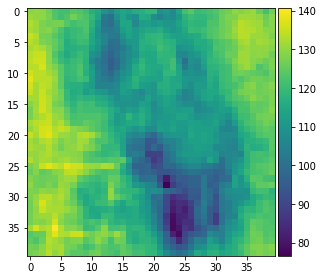

In [25]:
imshow(resized_orig.squeeze()[y1:y2, x1:x2])

In [12]:
pickle.dump(sym_dict, open('symm_1.p',"wb"))

In [28]:
pickle.dump(border_dict, open('bor_1.p',"wb"))

In [54]:
pickle.dump(border_dict, open('bor_2.p',"wb"))

In [16]:
pickle.dump(blue_dict, open('b_1.p',"wb"))
pickle.dump(green_dict, open('g_1.p',"wb"))
pickle.dump(red_dict, open('r_1.p',"wb"))